## Introduction
Joe is a new freshman at Carnegie Mellon University. It is his first time in Pittsburgh and he is not familiar with the restaurants here. He wants to explore the different dining options for different occasions. However, as a busy CS student, he doesn’t have much time to do so. As his friends, we will be helping him to analyze and visualize Pittsburgh restaurant data using the [Yelp Fusion API](https://fusion.yelp.com/). We will be specifically focusing on the different characteristics (i.e. price, popularity, cuisine distribution, etc.) of restaurants in different regions of Pittsburgh. 

We will create visualizations that Joe can use to find restaurants for his needs quickly and easily. We will also create spatial data visualizations so Joe can related neighorhood characteristics to their geographical locations. At the end of this project, we will list out some observations that resulted from this analysis of the Yelp data.

## Installing Libraries
Let us first install the various library that we will use to analysis Pittsburgh restaurants for Joe. We can install the libraries by running the following commands.
  ``` 
  $ python -m pip install pandas 

  $ python -m pip install requests

  $ python -m pip install time

  # python -m pip install matplotlib

  $ python -m pip install seaborn

  $ python -m pip install tqdm

  $ python -m pip install descartes

  $ python -m pip install geopandas

  $ python -m pip install shapely

  $ python -m pip install random
  ```

Run the following cell to import the libraries into the notebook.

In [1]:
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import random
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

## Collecting Yelp Restaurant Data


The way we will collect data on Pittsburgh restaurants is through querying the [Yelp Fusion API](https://fusion.yelp.com/). The Yelp API contains a [business search](https://www.yelp.com/developers/documentation/v3/business_search) endpoint which we can use to search for Pittsburgh restaurants. This is very similar to what we have done in homework 1. To this end, we can reuse some of our code from that assignment to use the Requests library to query the endpoint. 

In order to use the Yelp Fusion API, you will need to generate an [API key](https://www.yelp.com/developers/v3/manage_app).

In [2]:
API_KEY = "55OogUtwnlPBe3XofvQBDpHxADO1WaxgA1JFjegDtimMsoX6oqTkVJ6Gx2ry7g07D_qxm3Hdnk_cAziTh_so6rwjekkLoNDZrvTVm2_nJLuida5u70FgaFSYQrz5YXYx"

We will reuse the ```yelp_search``` function from homework 1.

In [3]:
def yelp_search(query):
    """
    Make an authenticated request to the Yelp API.

    Args:
        query (string): Search term

    Returns:
        total (integer): total number of businesses on Yelp corresponding to the query
        businesses (list): list of dicts representing each business
    """

    payload = {'location': query}
    headers = {'Authorization': 'Bearer '+ API_KEY}
    response = requests.get("https://api.yelp.com/v3/businesses/search", headers=headers, params=payload)
    response.raise_for_status()
    json = response.json()

    return json['total'], json['businesses']

In homework 1, we retrieved Pittsburgh businesses and stored it as a list of JSON business objects. In order to best help Joe through conducting analysis on the data, we will alter the ```all_restaurants``` function to return a normalized Pandas dataframe instead. 

We can use the [pandas.json_normalize](https://pandas.pydata.org/docs/reference/api/pandas.json_normalize.html) function to flatten the structure of the JSON response object from the Yelp API into a dataframe. This won't completely noramlize all columns (ex. transactions and categories) in the dataframe so we will have to separately deal with them later on. 

In [4]:
def all_restaurants(query):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term

    Returns:
        results (pd.DataFrame): dataframe of businesses
    """

    payload = {'location': query, 'categories': 'restaurants', 'limit': 50}
    headers = {'Authorization': 'Bearer '+ API_KEY}
    offset = 0
    res = []
    
    # call endpoint until no additional data is received
    while(offset < 1000):
        payload['offset'] = offset
        try:
            response = requests.get("https://api.yelp.com/v3/businesses/search", headers=headers, params=payload)
            response.raise_for_status()
        except requests.exceptions.HTTPError:
            break
        
        json = response.json()

        if len(json['businesses']) < 1:
            break

        offset += len(json['businesses'])
        res.extend(json['businesses'])
        time.sleep(0.5)
    return pd.json_normalize(res)

The limitation of the [business search](https://www.yelp.com/developers/documentation/v3/business_search) endpoint is that it can only return up to 1000 businesses for a single search using the pagination values. We will attempt to get more data by searching restaurants in each possible ZipCode for Pittsburgh. We will then remove the duplicate restaurants to get a master list of Pittsburgh restaurants. Generating the master list takes a decently long time (est. 10 min). We can visualize this using the ```tqdm``` progress bar.

In [5]:
master_df = pd.DataFrame()
pittsburgh_zipcodes = [15106, 15120, 15201, 15203, 15204, 15205, 15206, 15207, 15208, 15210, 15211, 15212, 15213, 15214, 15215, 15216, 15217, 15218, 15219, 15220, 15221, 15222, 15224, 15226, 15227, 15232, 15233, 15234, 15235, 15236, 15238, 15260, 15290]

# est. runtime 10 min
for zip in tqdm(pittsburgh_zipcodes):
  df = all_restaurants(zip)
  # strict checking of zip code, can comment out for more data
  df = df[df['location.zip_code'] == str(zip)]
  master_df = pd.concat([master_df, df])

# remove duplicate restaurants
master_df = master_df.drop_duplicates(subset=['id'])


100%|██████████| 33/33 [10:36<00:00, 19.29s/it]


We can see that this method gives us roughly 1450 restaurants. Now its time to use this data to help Joe become more familiar with Pittsburgh restaurants!

In [19]:
master_df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address,geometry
0,dYlBcBLp3KY5Tc78d8k0ow,brick-n-mortar-kitchen-and-catering-heidelberg-2,Brick N' Mortar Kitchen & Catering,https://s3-media2.fl.yelpcdn.com/bphoto/iV5ccg...,False,https://www.yelp.com/biz/brick-n-mortar-kitche...,171,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",4.5,[delivery],...,-80.087645,1709 E Railroad St,,None,Heidelberg,15106,US,PA,"[1709 E Railroad St, Heidelberg, PA 15106]",POINT (-80.08765 40.39153)
1,jhGbILmSQ2TQvpJWug49Ew,carnegie-coffee-company-carnegie,Carnegie Coffee Company,https://s3-media2.fl.yelpcdn.com/bphoto/xltDkT...,False,https://www.yelp.com/biz/carnegie-coffee-compa...,195,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",4.5,[delivery],...,-80.086108,132 E Main St,,,Carnegie,15106,US,PA,"[132 E Main St, Carnegie, PA 15106]",POINT (-80.08611 40.40776)
3,eMIX3ldCrPJymVenND0sDg,one-thirty-one-east-carnegie,One Thirty One East,https://s3-media3.fl.yelpcdn.com/bphoto/GRXgzK...,False,https://www.yelp.com/biz/one-thirty-one-east-c...,191,"[{'alias': 'newamerican', 'title': 'American (...",4.5,[delivery],...,-80.086150,131 E Main St,,,Carnegie,15106,US,PA,"[131 E Main St, Carnegie, PA 15106]",POINT (-80.08615 40.40801)
5,dP8_X1zpSo3rGarHMyzQ1A,leogreta-carnegie,LeoGreta,https://s3-media1.fl.yelpcdn.com/bphoto/IGU5Vt...,False,https://www.yelp.com/biz/leogreta-carnegie?adj...,167,"[{'alias': 'italian', 'title': 'Italian'}, {'a...",4.5,[delivery],...,-80.091270,301 W Main St,,None,Carnegie,15106,US,PA,"[301 W Main St, Carnegie, PA 15106]",POINT (-80.09127 40.40432)
7,alfg8YykqggAUbeyd2nzmw,insurrection-aleworks-heidelberg,Insurrection AleWorks,https://s3-media2.fl.yelpcdn.com/bphoto/rYSQoY...,False,https://www.yelp.com/biz/insurrection-aleworks...,145,"[{'alias': 'breweries', 'title': 'Breweries'},...",4.5,[delivery],...,-80.087402,1635 E Railroad St,,,Heidelberg,15106,US,PA,"[1635 E Railroad St, Heidelberg, PA 15106]",POINT (-80.08740 40.39245)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,2XZ4g_ps_H55CmxFs4Pu8A,chilis-pittsburgh,Chili's,https://s3-media2.fl.yelpcdn.com/bphoto/wpQNgf...,False,https://www.yelp.com/biz/chilis-pittsburgh?adj...,53,"[{'alias': 'tex-mex', 'title': 'Tex-Mex'}, {'a...",2.5,[],...,-79.891602,855 Freeport Rd,None,None,Pittsburgh,15238,US,PA,"[855 Freeport Rd, Pittsburgh, PA 15238]",POINT (-79.89160 40.48692)
863,I-D4qEtJJ4okSLrLKxMMRw,burger-king-pittsburgh-13,Burger King,https://s3-media4.fl.yelpcdn.com/bphoto/eXdff-...,False,https://www.yelp.com/biz/burger-king-pittsburg...,9,"[{'alias': 'hotdogs', 'title': 'Fast Food'}, {...",3.5,[delivery],...,-79.833244,2799 Freeport Rd,None,None,Pittsburgh,15238,US,PA,"[2799 Freeport Rd, Pittsburgh, PA 15238]",POINT (-79.83324 40.53853)
864,i851zomQeoY7gbrkFcvM7Q,dennys-pittsburgh-4,Denny's,https://s3-media2.fl.yelpcdn.com/bphoto/-JtXII...,False,https://www.yelp.com/biz/dennys-pittsburgh-4?a...,30,"[{'alias': 'diners', 'title': 'Diners'}, {'ali...",2.5,"[pickup, delivery]",...,-79.834410,2701 Freeport Rd,,,Pittsburgh,15238,US,PA,"[2701 Freeport Rd, Pittsburgh, PA 15238]",POINT (-79.83441 40.53832)
978,2A9gJkmWbBVoh6kK0jDlxA,la-pizza-bella-pittsburgh,La Pizza Bella,,False,https://www.yelp.com/biz/la-pizza-bella-pittsb...,6,"[{'alias': 'italian', 'title': 'Italian'}, {'a...",4.0,"[pickup, delivery]",...,-79.862587,268 Freeport Rd,Ste 1,None,Pittsburgh,15238,US,PA,"[268 Freeport Rd, Ste 1, Pittsburgh, PA 15238]",POINT (-79.86259 40.49282)


## Number of Restaurants per ZipCode

Now that we have a master list of Pittsburgh restaurants, we can do some visualizations to give Joe some insights. Joe is particularly intersted in the characteristics of restaurants in different neighborhoods. We will define neighborhoods through zipcodes. Lets first show Joe the distribution of restaurants across different Pittsburgh zipcodes.

We can see that the majority of the zipcode areas have above 25 restaurants with 15213 and 15222 being the most densely concentrated. On the other hand, 15204 and 15214 has the fewest amount of restaurants. Luckily, Joe is located in 15213 so he has a variety of options close to home.

<AxesSubplot:title={'center':'Number of Restaurant by ZipCode'}, xlabel='ZipCode', ylabel='Count'>

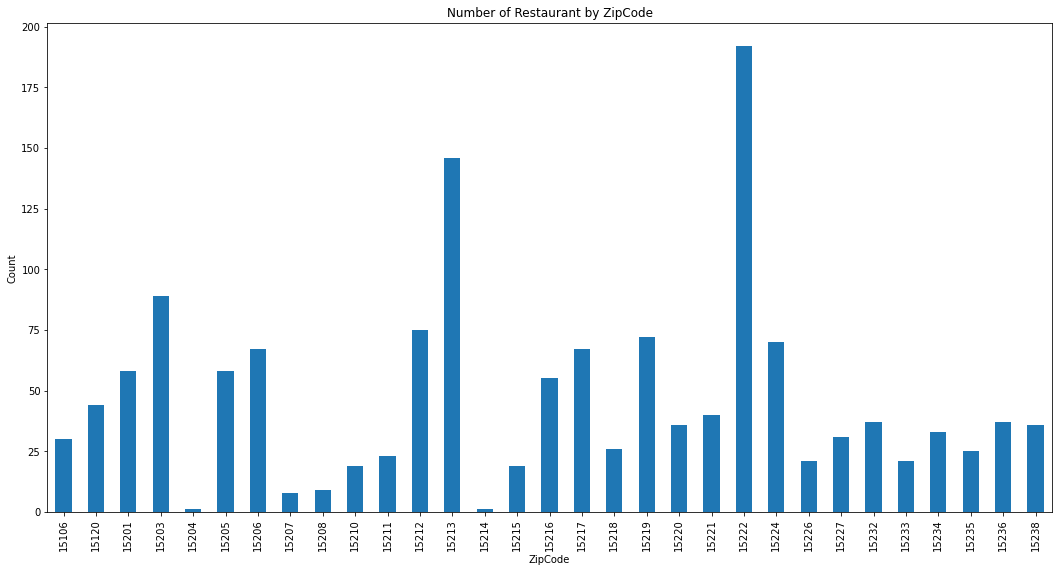

In [7]:
count_zip = master_df.groupby('location.zip_code').size()
count_zip.plot.bar(xlabel="ZipCode", ylabel="Count", title="Number of Restaurant by ZipCode", figsize=(18,9))

## Distribution of Restaurant Transaction Type by ZipCode

Joe loves eating in at restaurants but his CS workload has been pretty heavy these days. In order to save some time, Joe often orders delivery or pickup and eats on campus or at home. Let us visualize the distribution of transaction types across zipcodes. 

The ```transactions``` column in the dataframe is a list, so lets ```explode``` it to make those cells atomic. After that, we can groupby ```zipcode``` then get the counts for each transaction type.

<AxesSubplot:title={'center':'Restaurant Transaction Type by ZipCode'}, xlabel='ZipCode', ylabel='Count'>

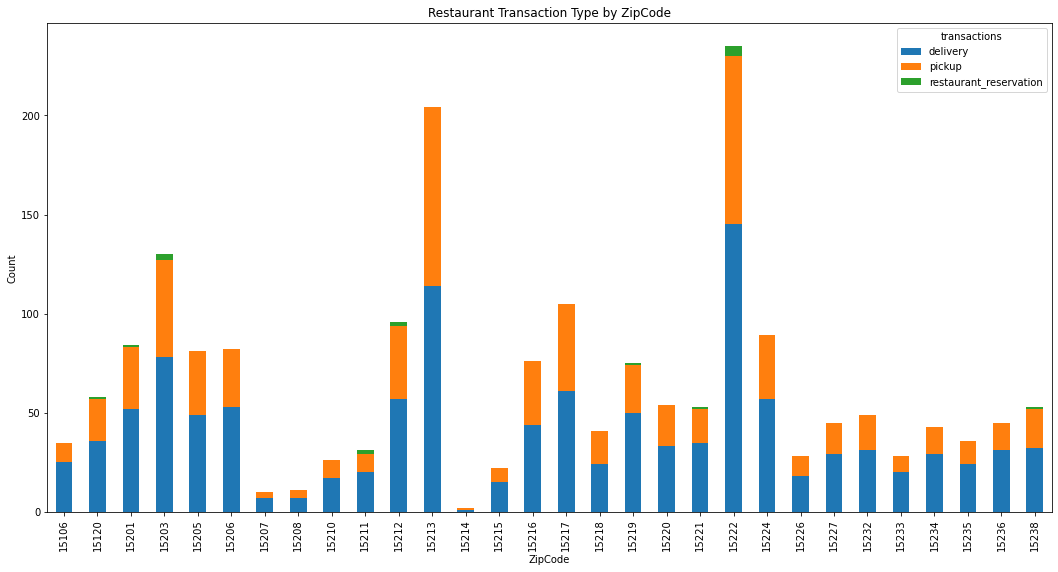

In [8]:
transactions_df = master_df.explode('transactions')
transactions_df = transactions_df.dropna(subset=['transactions'])
transactions_gp = transactions_df.groupby('location.zip_code')['transactions'].value_counts().unstack().fillna(0)
transactions_gp.plot.bar(stacked=True, title="Restaurant Transaction Type by ZipCode", xlabel="ZipCode", ylabel="Count", figsize=(18,9))

## Distribution of Restaurant Price by ZipCode

As with most college students, Joe doesn't have the means to eat at Michelin 3 star restaurant everyday. Joe prefers to eat at restaurants where he gets the best value out of his money. Let us visualize the distribution of restaurant price by zipcode. 

We can do something similar as the restaurant transaction type graph above.

<AxesSubplot:title={'center':'Restaurant Price by ZipCode'}, xlabel='ZipCode', ylabel='Count'>

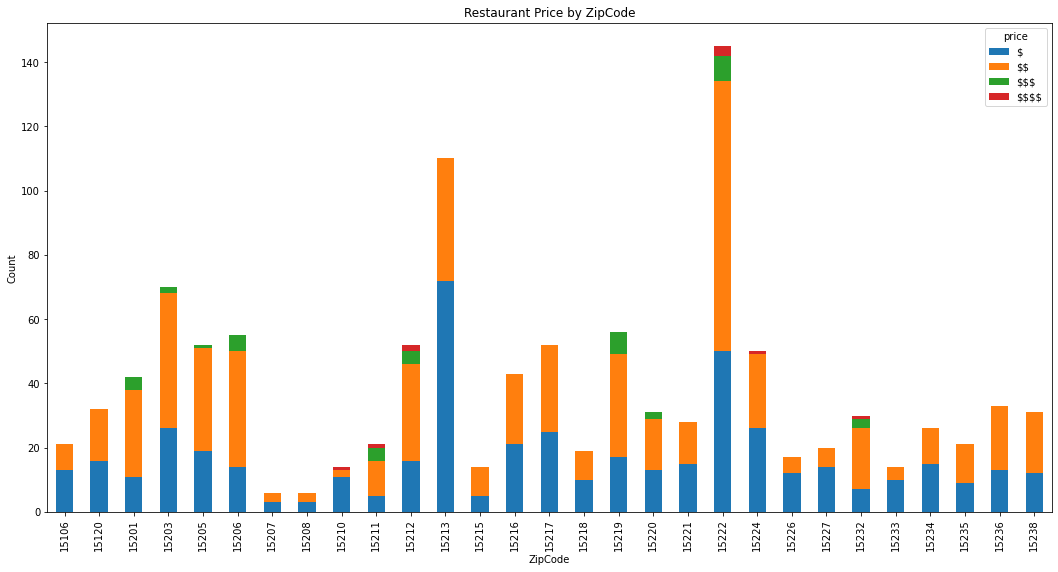

In [9]:
price_df = master_df.dropna(subset=['price'])
price_gp = price_df.groupby('location.zip_code')['price'].value_counts().unstack().fillna(0)

# add escape char to '$' to avoid parsing error
price_gp = price_gp.rename(columns={'$': '\$', '$$': '\$\$', '$$$': '\$\$\$', '$$$$': '\$\$\$\$'})
price_gp.plot.bar(stacked=True, title="Restaurant Price by ZipCode", xlabel="ZipCode", ylabel="Count", figsize=(18,9))

We can see that 15222 has the most number of restaurants rated at $$$$ price point. Just in case Joe is feeling boujee after cashing in his TA paycheck, lets list out those restaurants for him.

In [22]:
master_df[(master_df['location.zip_code'] == '15222') & (master_df['price'] == '$$$$')]['name']

28         The Capital Grille
87    Ruths Chris Steak House
96    Morton's The Steakhouse
Name: name, dtype: object

## Distribution of Chinese Restaurant Star Rating by ZipCode

Joe has been really into Chinese food these days. And it makes him wonder, which neighborhoods have the best Chinese restaurants? We can use star rating as an indicator of how good a restaurant is. Using a violin plot, lets show the distribution of restaurant star ratings for each zipcode. 

First, we have to make the ```categories``` column atomic by ```exploding``` the list of categories. We then filter by ```Chinese``` restaurants only then pass the dataframe to the ```seaborn``` violin plot.

In [11]:
categories_df = master_df.explode('categories')
categories_df['categories'] = categories_df['categories'].apply(lambda x: x['title'])

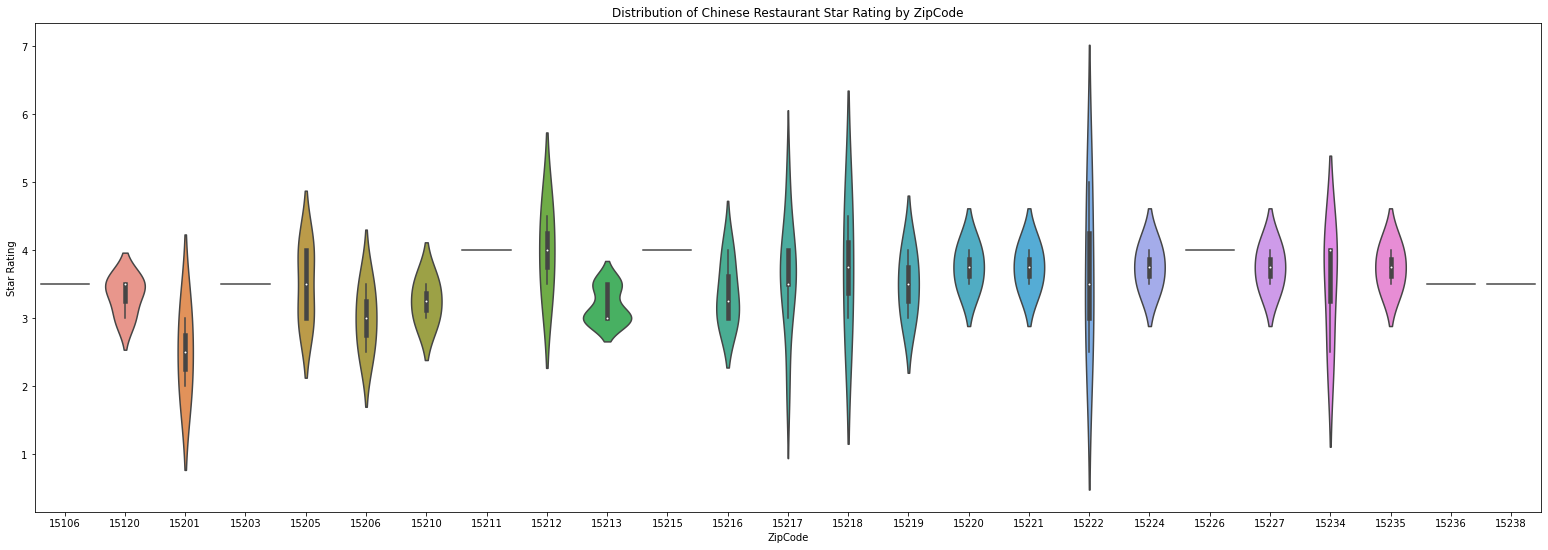

In [12]:
t = categories_df[categories_df['categories'] == 'Chinese']
t = t[['location.zip_code', 'rating']]
fig, ax = plt.subplots(figsize=(27,9))
ax = sns.violinplot(x='location.zip_code', y='rating', data=t)
ax.set_xlabel('ZipCode')
ax.set_ylabel('Star Rating')
ax.set_title('Distribution of Chinese Restaurant Star Rating by ZipCode')
plt.show()

From the chart, we see that 15222 has the widest range of star rating for Chinese restaurants. This may be because 15222 contains the most amount of restaurants out of all the Pittsburgh zipcodes. 

## Distribution of Restaurant Star Rating by ZipCode (might remove)

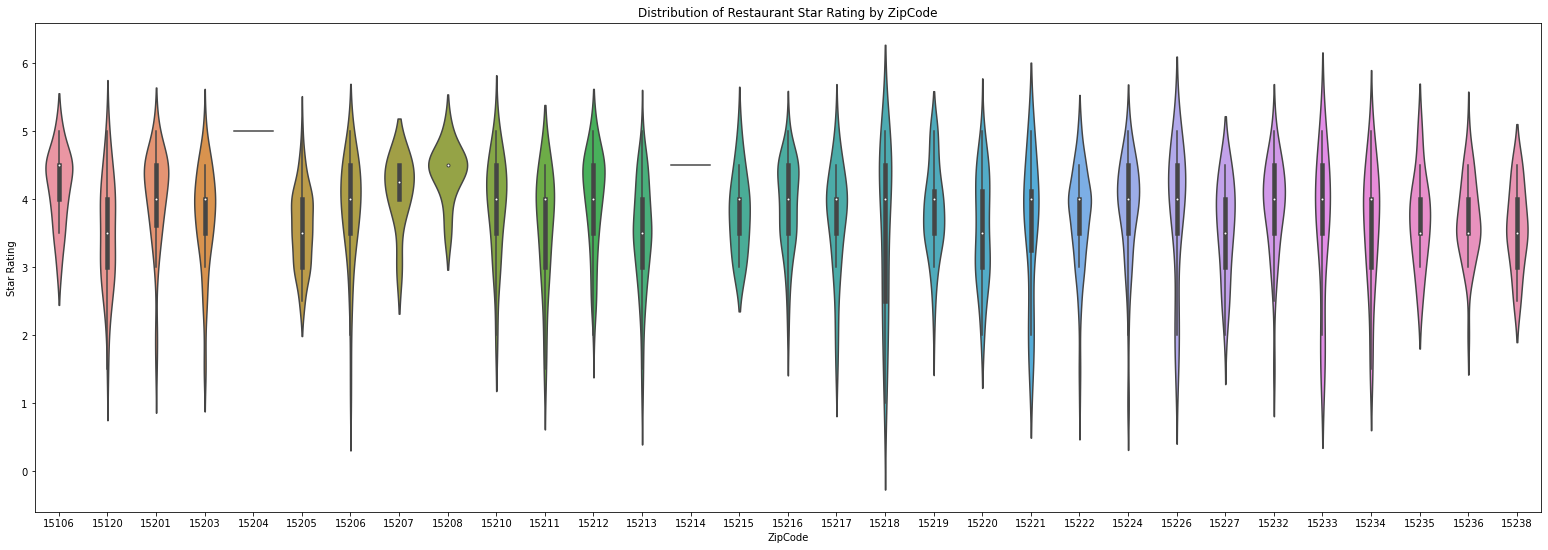

In [13]:
t = master_df[['location.zip_code', 'rating']]
fig, ax = plt.subplots(figsize=(27,9))
ax = sns.violinplot(x='location.zip_code', y='rating', data=t)
ax.set_xlabel('ZipCode')
ax.set_ylabel('Star Rating')
ax.set_title('Distribution of Restaurant Star Rating by ZipCode')
plt.show()

## Spatial Data Analysis

<AxesSubplot:>

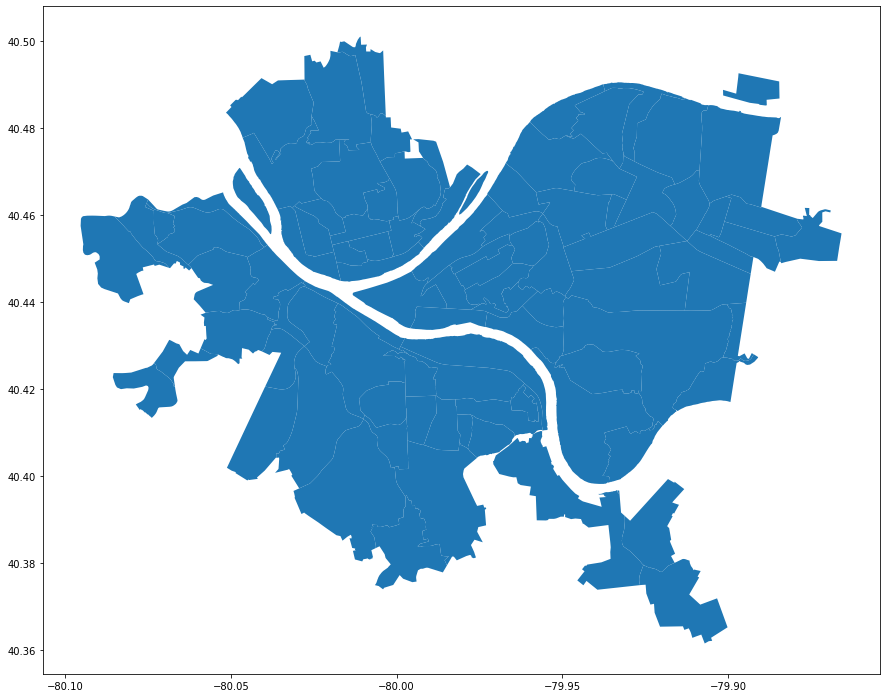

In [14]:
street_map = gpd.read_file('kx-pittsburgh-pa-neighborhoods-SHP/pittsburgh-pa-neighborhoods.shp')
# street_map = gpd.read_file('AlleghenyCounty_StreetCenterlines202204/AlleghenyCounty_StreetCenterlines202204.shp')

fig, ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax)

## Plotting Pittsburgh Restaurants on Map

In [15]:
import random
r = lambda: random.randint(0,255)
print('#%02X%02X%02X' % (r(),r(),r()))
colors = []

for i in range(len(pittsburgh_zipcodes)):
    while True:
        c = '#%02X%02X%02X' % (r(),r(),r())
        if c not in colors: break
    colors.append(c)

print(colors)

#C04EC2
['#059C2D', '#DC8B5E', '#3CDCD6', '#623AB7', '#EB84AC', '#A9855A', '#F6E113', '#F013BA', '#2D7D9E', '#69F836', '#289F1E', '#33ACCD', '#7E9F5C', '#195E99', '#F1F48C', '#5814D6', '#69E0F3', '#6F9252', '#364AB7', '#6FB7BD', '#254D31', '#DD4583', '#1C1A0A', '#CB7700', '#15A05B', '#B1C0CA', '#74721E', '#2677B4', '#37C510', '#E90834', '#DA212D', '#CB1BBA', '#43F870']


C:\Users\purpl\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\purpl\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


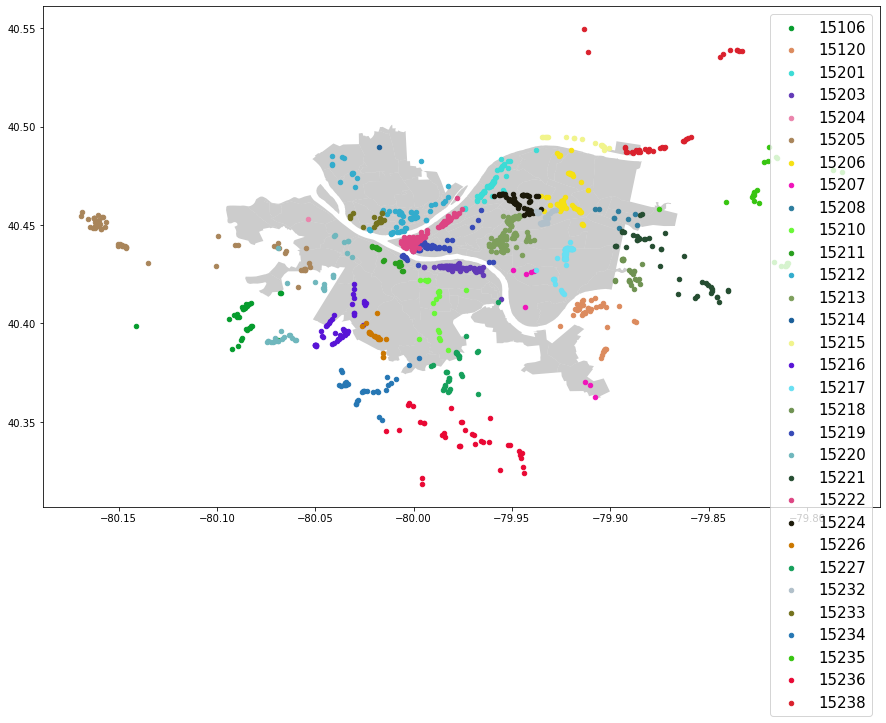

In [16]:
street_map = gpd.read_file('kx-pittsburgh-pa-neighborhoods-SHP/pittsburgh-pa-neighborhoods.shp')
# street_map = gpd.read_file('AlleghenyCounty_StreetCenterlines202204/AlleghenyCounty_StreetCenterlines202204.shp')

fig, ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
gdf = gpd.GeoDataFrame(master_df, geometry=gpd.points_from_xy(master_df["coordinates.longitude"], master_df["coordinates.latitude"]))
for i in range(len(pittsburgh_zipcodes)):
    zipcode = str(pittsburgh_zipcodes[i])
    color = colors[i]
    gdf[gdf['location.zip_code'] == zipcode].plot(ax=ax, markersize=20, color=color, label=zipcode)
plt.legend(prop={'size':15})